# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

## Due: Midnight on October 5th (with 2-hour grace period) and worth 85 points

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **LR schedules**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed / exponential / cosine), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model. 

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [1]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        # print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [3]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 100,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default 
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,                  
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),      
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  

In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

In [5]:
# Reproducible load + preprocess for Intel Image Classification

IMG_SHAPE = (224,224,3)
IMG_SIZE = IMG_SHAPE[:2]

# -------------------------
# Loader (deterministic)
# -------------------------

def load_data_from_directory(directory, img_size=IMG_SIZE, class_names=None, preprocess="mobilenet_v2"):
    """
    Loads images as float32 and integer labels.
    If preprocess == 'mobilenet_v2', outputs are scaled to [-1, 1] as expected by MobileNetV2.
    Else, outputs are scaled to [0,1].
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img).astype("float32")  # values in [0,255]
            if preprocess == "mobilenet_v2":
                # Official Keras preprocessing: scales to [-1, 1]
                arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            else:
                arr = arr / 255.0  # your original behavior
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = np.stack(X).astype("float32")
    y = np.array(y, dtype="int32")
    return X, y, class_names


In [6]:
# Load full training set (preprocessed for MobileNetV2)
X_all, y_all, class_names = load_data_from_directory(
    train_dir, img_size=IMG_SIZE , preprocess="mobilenet_v2"
)

# 80/20 stratified split -> train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=random_seed,
    shuffle=True,
)

# Load test set using same class mapping + preprocessing
X_test, y_test, _ = load_data_from_directory(
    test_dir, 
    img_size=IMG_SIZE, 
    class_names=class_names
)

num_classes = len(class_names)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

print(f'num_classes: {num_classes}')
print('Class Names:', class_names)

Train: (11227, 224, 224, 3) (11227,)
Val:   (2807, 224, 224, 3) (2807,)
Test:  (3000, 224, 224, 3) (3000,)
num_classes: 6
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Examine The Dataset

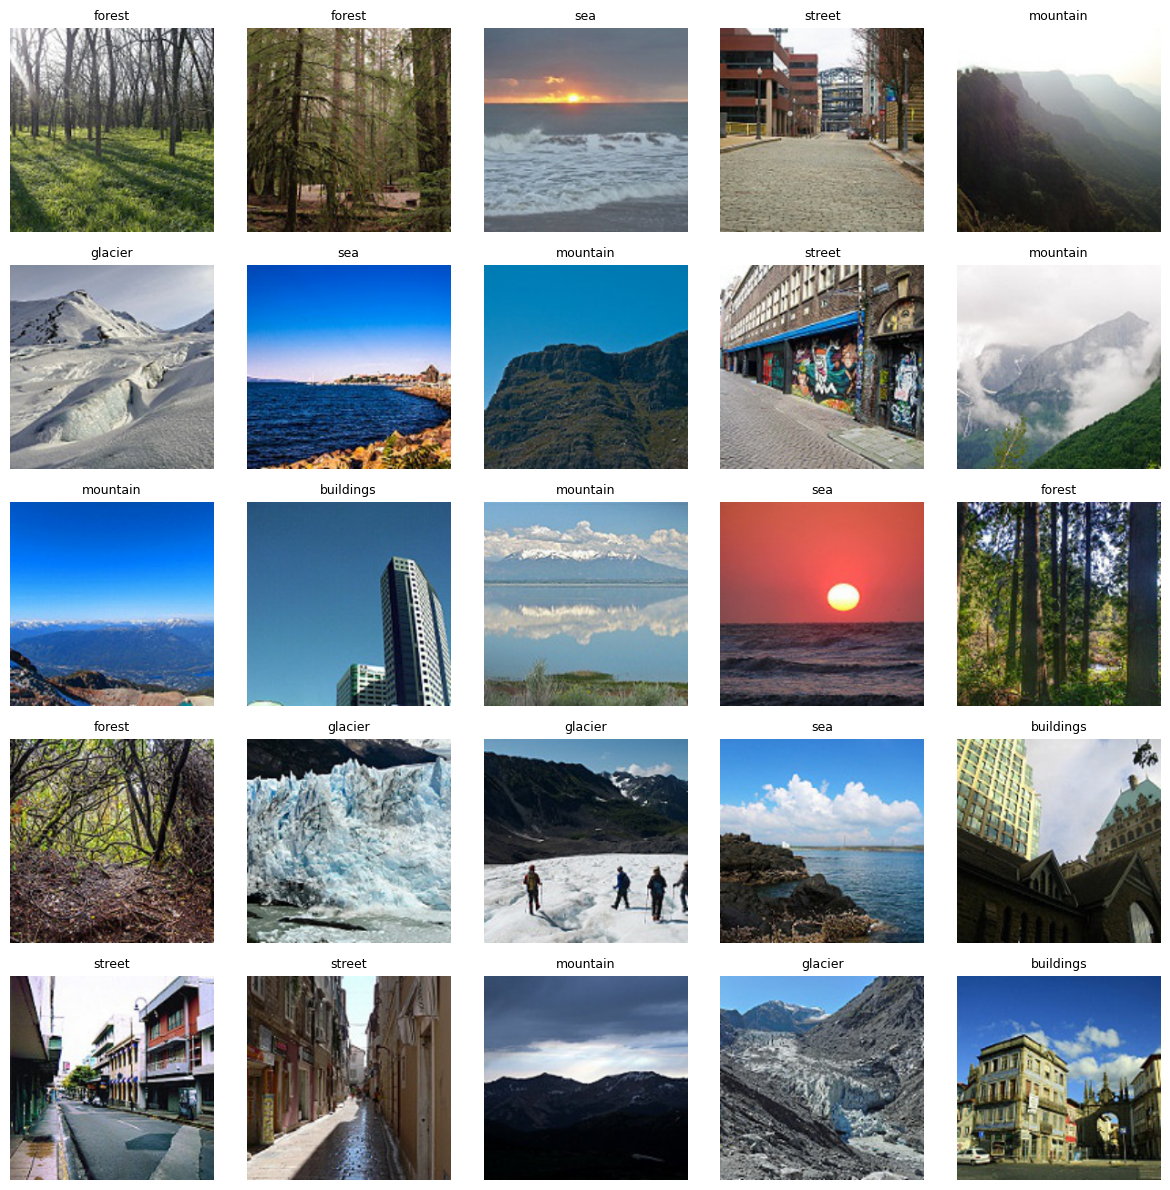

In [7]:
# pick 25 random, distinct indices
idx = np.random.choice(len(X_train), size=25, replace=False)

plt.figure(figsize=(12, 12))
for k, i in enumerate(idx, start=1):
    ax = plt.subplot(5, 5, k)
    ax.imshow((X_train[i] + 1.0) / 2.0)
    # if y_train is one-hot, take argmax; otherwise use the label directly
    label_idx = int(np.argmax(y_train[i])) if getattr(y_train, "ndim", 1) > 1 else int(y_train[i])
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Learning Rate Schedulers

In [8]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

In [9]:
# Both these must be input as lr_schedule in train_and_test(....   , lr_schedule=exp_decay, .... )

epochs = 100               # You'll need to adjust this to close to be close to the early stopping location
batch_size = 128

# Needed by LR schedulers

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`. 

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).



In [10]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=IMG_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base
    
base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

I0000 00:00:1758894265.292096 15198744 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1758894265.292134 15198744 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [11]:
# Ha, this is very long!

# base.summary()

In [12]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()               # default: trainable=False

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')  
])

train_and_test(model_baseline, title="Model Baseline")

## Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled()  # default: trainable=False
```


### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads and **give each experiment a unique descriptive title,** i.e., `title="Problem 1 Experiment 1"`
5. **Answer the graded questions.**

### Notes / Constraints

* The descriptive title will be used to compare results at the end of the notebook. 
* With `pooling="avg"`, This backbone already applies Global Average Pooling and outputs a **1280-D** feature vector per image. **Do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.


In [13]:
# Your code here; add as many cells as you need



### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.


**Your answer here:**




In [14]:
# Set a1 to the validation accuracy found by your best model for this problem. 

a1 = 0.0             # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem         

print(f'a1 = {a1}') 


a1 = 0.0


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—don’t add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **unfrozen**. Vary:

   * **Head choice** (pick one from Problem 1).
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**.
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (can combine with a fixed LR).
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 2 Experiment 1"`
3. **Answer the graded questions.**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook. 
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

In [16]:
# Your code here; add as many cells as you need


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your answer here:**





In [17]:
# Set a2 to the validation accuracy found by your best model for this problem. 

a2 = 0.0             # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem       

print(f'a2 = {a2:.4f}') 

a2 = 0.0000


## Problem Three: Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$** layers to fine-tune. (In Problem 4 you’ll try unfreezing the top **K blocks** instead.)

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model unfreeze the top $N$ layers using the following approach:

    N=20
    model = make_base_model_pooled()
    base_model.trainable = True
    for layer in base_model.layers[:-N]:
        layer.trainable = False

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen.** Vary hyperparameters such as:
   * $N\in \{20,40,60, 80\}$ 
   * **Head choice** (pick one from Problem 1).
   * **Learning rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay** (your choice of settings).
   * **Early Stopping** settings.
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (you can combine it with a fixed LR).
2. **Run and compare** the three experimentsand **give each experiment a unique descriptive title,** i.e., `title="Problem 3 Experiment 1"`
3. **Answer the graded questions**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

In [19]:
# Your code here; add as many cells as you need



### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your answer here:**




In [20]:
# Set a3 to the validation accuracy found by your best model for this problem. 

a3 = 0.0             # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3 = {a3:.4f}') 

a3 = 0.0000


## Problem Four: Unfreezing Convolution Blocks

After creating a model, unfreeze the top $K$ conv block using the following approach:

    block_prefixes = [
        'block_1', 'block_2', 'block_3', 'block_4',
        'block_5', 'block_6', 'block_7', 'block_8',
        'block_9', 'block_10', 'block_11', 'block_12',
        'block_13', 'block_14', 'block_15', 'block_16',
        'Conv_1',   # final 1×1 conv stage before pooling
    ]
    
    K = 3
        
    model = make_base_model_pooled(trainable=False)
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):           # Optional:  Often recommended to keep BN layers frozen
            layer.trainable = False                                         # Optional
        else:                                                               # Optiomal
            layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])




### To Do:

1. **Design at least three experiments** with the model having the **last K stages unfrozen**. Vary:

   * $K \in \{1,2,3,4,5\}$  *(K counts stages/blocks, not individual layers)*
   * **Unfreeze Batch Normalization** Layers or keep them frozen (see "Optional" in above code)
   * **Head choice** (pick one from Problem 1)
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** parameters
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 4 Experiment 1"`
3. **Answer the graded questions.**

**Notes**
* The descriptive title will be used to compare results at the end of the notebook. 
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

In [22]:
# Your code here; add as many cells as you need



### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks. 

**Your answer here:**




In [23]:
# Set a4 to the validation accuracy found by your best model for this problem. 

a4 = 0.0             # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4 = {a4:.4f}') 

a4 = 0.0000


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework. 

This reflection question is worth 5 points. 

In [25]:
# Print out summary of validation accuracy for each experiment

print_results()

### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your answer here:**




## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

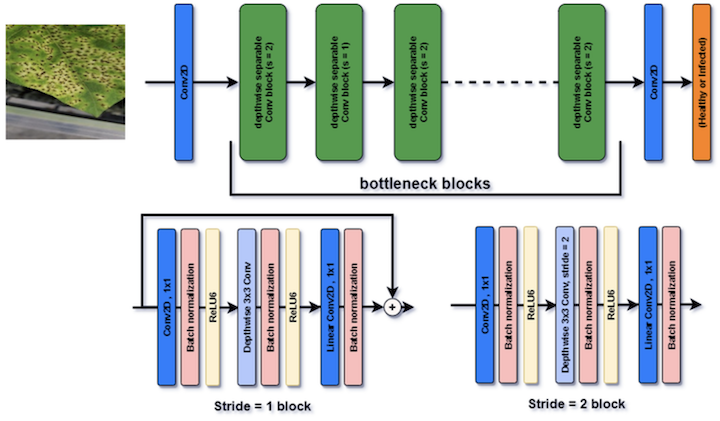


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### TL;DR Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
